# Predicting customer churn in a "like-for-like" hotel chain


**Project description:** The customer of this research is a hotel chain "As a guest". In order to attract customers, the hotel chain added to its website the possibility to book a room without prepayment. However, if the customer canceled the reservation, the company suffered losses. The hotel staff could, for example, purchase groceries for the guest's arrival or simply not have time to find another client. To solve this problem, we need to develop a system that predicts the abandonment of a reservation. If the model shows that the reservation will be canceled, the customer is asked to pay a deposit. The deposit amount is 80% of the room rate. The money will be deducted from the customer's account if they do cancel the reservation.

**Business Model and Other Data:**

The main business metric for any hotel chain is its profit. A hotel's profit is the difference between the cost of a room for all nights and the cost of a one-time service: both in preparing the room and the guest's stay. There are several types of rooms in a hotel. Depending on the type of room, a cost per night is assigned. There are also cleaning costs. If the client has rented a room for a long time, the room is cleaned every two days. The cost of the hotel rooms:

Category A: per night - 1,000, single service - 400;
Category B: per night - 800, single service - 350;
Category C: per night - 600, single service - 350;
Category D: per night - 550, single service - 150;
Category E: per night - 500, single service - 150;
Category F: 450 per night, one-time service - 150;
Category G: per night - 350, single service - 150;
category H: per night - 300, single service - 100.

The hotel price policy uses seasonal coefficients: in spring and fall the prices increase by 20%, in summer - by 40%. The budget for the development of the forecasting system is 400 000. It should be taken into account that the implementation of the model should pay off. The development costs should be less than the revenue that the system will bring to the company.

**Algorithm of work:**

1. Introduction
2. data review and preprocessing
3. Building the existing business model of the hotel
4. Development of an unreliable customer model
5. Let's describe the portrait of an "unreliable" customer
6. Calculating the profit of model implementation
7. General conclusion

**Data dictionary**
Known:

- ADR - average daily occupancy;
- Adults - number of adult guests;
- Agent - agent through whom the reservation was made;
- AssignedRoomType - room type;
- Babies - number of infants;
- BookingChanges - number of changes of booking parameters;
- Children - number of children from 3 to 14 years old;
- CompanyID - ID of the company or legal entity responsible for the booking.
- Country - nationality of the guest;
- CustomerType - type of customer:
    Contract - contract with a legal entity;
    Group - group check-in;
    Transient - not related to contract or group check-in;
    Transient-party - not associated with a contract or group check-in, but associated with a reservation of type Transient.
- DaysInWaitingList - how many days the order has been waiting for confirmation;
- DistributionChannel - the distribution channel of the order;
- IsCanceled - canceled order;
- IsRepeatedGuest - an indication that the guest is booking for the second time;
- LeadTime - number of days between booking date and arrival date;
- Meal - order options:
    SC - no additional options;
    BB - breakfast included;
    HB - breakfast and lunch included;
    FB - breakfast, lunch and dinner included.
- PreviousBookingsNotCanceled - number of confirmed orders at the client;
- PreviousCancellations - number of canceled orders at the customer;
- RequiredCardParkingSpaces - the need for car parking space;
- ReservedRoomType - type of room booked;
- StaysInWeekendNights - number of nights on weekends;
- StaysInWeekNights - number of nights on weekdays;
- TotalOfSpecialRequests - number of special check-ins.

**Target attribute:**

IsCanceled - canceled order;

## Step 1. Open the data files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, Normalizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_curve, roc_auc_score


In [2]:
train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')

In [3]:
#Let's look at the sample sizes
print(f'Размер обучающей выборки: {train.shape}')
print(f'Размер тестовой выборки: {test.shape}')


Размер обучающей выборки: (65229, 25)
Размер тестовой выборки: (32412, 25)


In [4]:
train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [5]:
test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [6]:
print('==== Обучающая выборка ====')
print(train.info())
print('Количество дубликатов:', sum(train.duplicated()))
print('==== Тестовая выборка ====')
print(test.info())
print('Количество дубликатов:', sum(test.duplicated()))

==== Обучающая выборка ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal

In [7]:
print('==== Обучающая выборка ====')
print('Количество дубликатов:', sum(train.drop('id',axis=1).duplicated()))
print('==== Тестовая выборка ====')
print('Количество дубликатов:', sum(test.drop('id',axis=1).duplicated()))

==== Обучающая выборка ====
Количество дубликатов: 21377
==== Тестовая выборка ====
Количество дубликатов: 7717


## Step 2: Pre-processing and exploratory data analysis

### Pre-processing

In [8]:
round(train.isnull().mean()*100,2) 

id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

In [9]:
round(test.isnull().mean()*100,2) 

id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

No duplicates or missing values detected

In the columns lead_time, adults, children, babies, change the data type from real float64 to integer int64.

In [10]:
train[['lead_time', 'adults', 'children', 'babies']] = train[
    ['lead_time', 'adults', 'children', 'babies']
].astype('int')

**Check** implicit duplicates

In [11]:
categ_cols = [
    'arrival_date_month', 'country', 'meal', 
    'distribution_channel', 'reserved_room_type', 
    'customer_type'
]

In [12]:
for col in categ_cols:
    print(col, sorted(train[col].unique()), sep=': ', end='\n\n')

arrival_date_month: ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']

country: ['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 'NAM', 'NGA', 'NIC', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRI', 'PRT', 'PRY', 'PYF', 'QAT', 

Let's remove empty characters at the end of the string in the `meal`,`reserved_room_type` columns

In [13]:
for col in ['meal','reserved_room_type']:
    train[col] = train[col].str.strip()
    print(train[col].unique())

['BB' 'FB' 'HB' 'SC']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


In [14]:
train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [15]:
train['babies'].unique()

array([ 0,  1,  2, 10,  9])

In [16]:
train.query('babies > 2')['babies'].count()

2

10 and 9 are outliers, get rid of them.

In [17]:
train = train.query('babies <= 2').reset_index(drop=True)

In [18]:
print(train['babies'].value_counts())
print('----------------------------')
print(test['babies'].value_counts())

0    64777
1      447
2        3
Name: babies, dtype: int64
----------------------------
0.0    32237
1.0      171
2.0        4
Name: babies, dtype: int64


In [19]:
train.loc[train['babies']==2, 'babies'] = 1
test.loc[test['babies']==2, 'babies'] = 1

train = train.rename(columns={'babies':'has_babies'})
test = test.rename(columns={'babies':'has_babies'})


processed and renamed the feature


Let's check the data in the test dataset

In [20]:
for col in categ_cols:
    print(col, sorted(test[col].unique()), sep=': ', end='\n\n')

arrival_date_month: ['April', 'August', 'February', 'January', 'July', 'June', 'March', 'May']

country: ['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM', 'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KIR', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MLT', 'MNE', 'MOZ', 'MRT', 'MUS', 'MYS', 'MYT', 'NCL', 'NGA', 'NLD', 'NOR', 'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRT', 'PRY', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 'SLV', 'SRB', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SYC', 'SYR', 'TGO',

Some columns also contain empty characters at the end of the row, let's get rid of them

In [21]:
for col in ['meal','reserved_room_type']:
    test[col] = test[col].str.strip()

Let's remove the uninformative columns: 'id', 'arrival_date_week_number'

In [22]:
columns1 = ['id', 'arrival_date_week_number']

test = test.drop(columns=columns1, axis=1)
train = train.drop(columns=columns1, axis=1)

### Exploratory analysis

Let's look at the distribution of target attributes

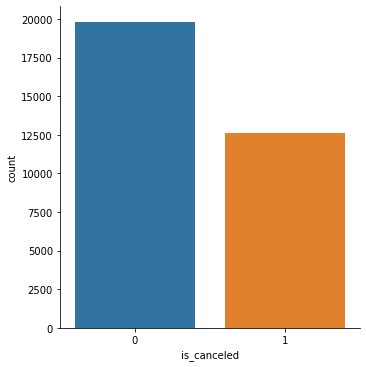

In [23]:

sns.catplot(data=test, x='is_canceled', kind='count')

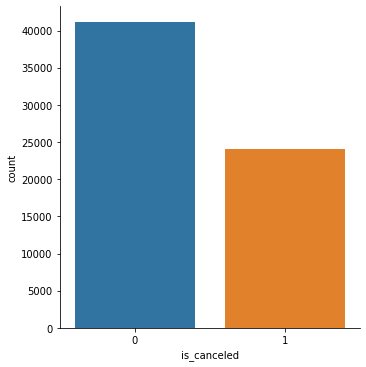

In [24]:
sns.catplot(data=train, x='is_canceled', kind='count')

For convenience, let's group the attributes

In [25]:
# Categorical
categorical = ['distribution_channel', 'customer_type', 'reserved_room_type','meal','country']

# Numeric
numeric = ['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled',
           'booking_changes', 'days_in_waiting_list']

# Real numbers, with a small number of unique values
numeric_cat = ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
               'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']

# Boolean values
bools = ['is_canceled', 'is_repeated_guest', 'has_babies']

# Time and date
date_time = ['arrival_date_year', 'arrival_date_month',  'arrival_date_day_of_month']

Распределение distribution_channel в обучающем TA/TO        54453
Direct        6853
Corporate     3822
GDS             99
Name: distribution_channel, dtype: int64
Распределение distribution_channel в тестовом TA/TO        27083
Direct        3642
Corporate     1602
GDS             85
Name: distribution_channel, dtype: int64
Распределение customer_type в обучающем Transient          45492
Transient-Party    16702
Contract            2746
Group                287
Name: customer_type, dtype: int64
Распределение customer_type в тестовом Transient          27461
Transient-Party     4427
Contract             359
Group                165
Name: customer_type, dtype: int64
Распределение reserved_room_type в обучающем A    50500
D     9386
E     2448
F     1213
B      860
G      592
C      228
Name: reserved_room_type, dtype: int64
Распределение reserved_room_type в тестовом A    23471
D     6123
E     1644
F      503
G      278
C      201
B      192
Name: reserved_room_type, dtype: int64
Распр

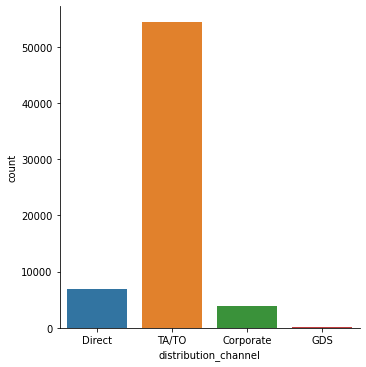

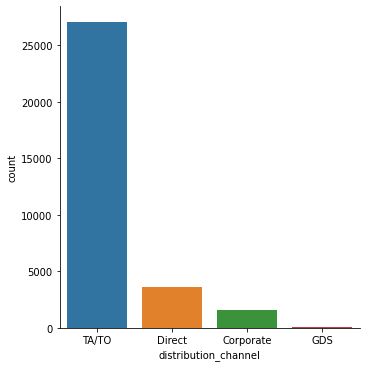

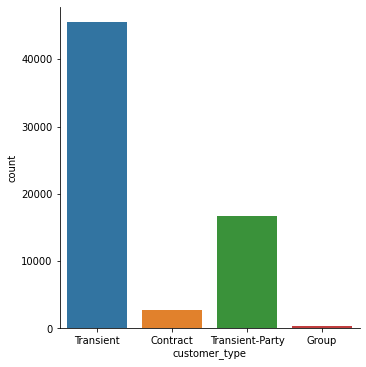

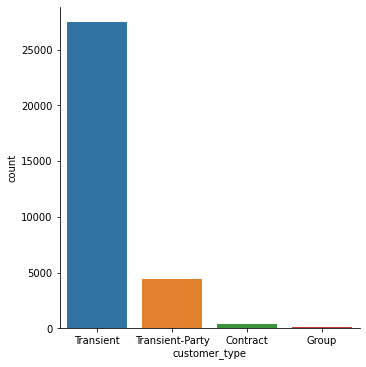

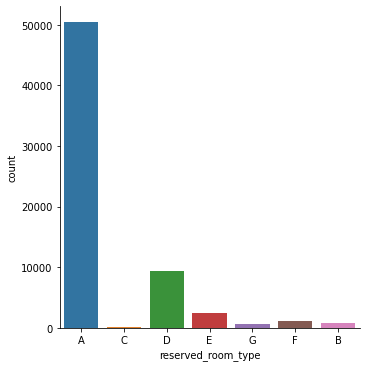

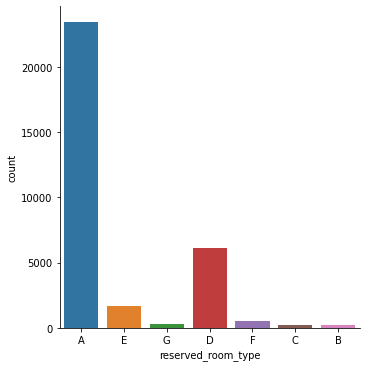

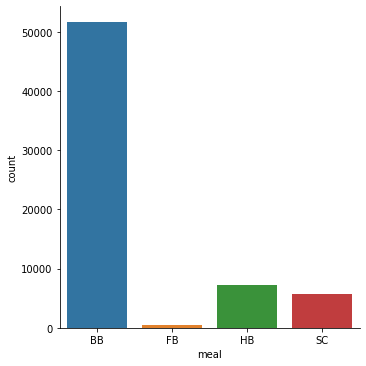

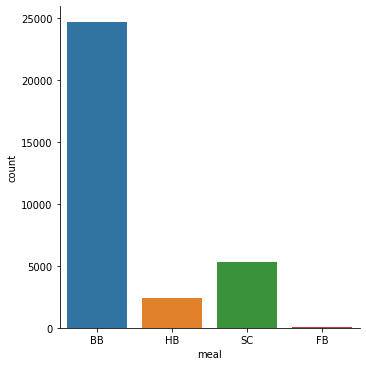

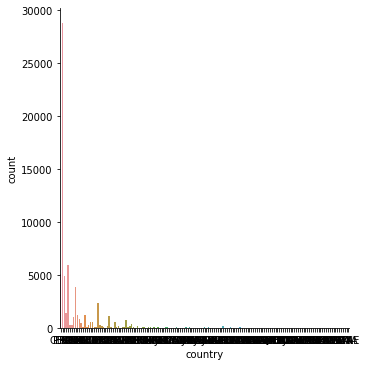

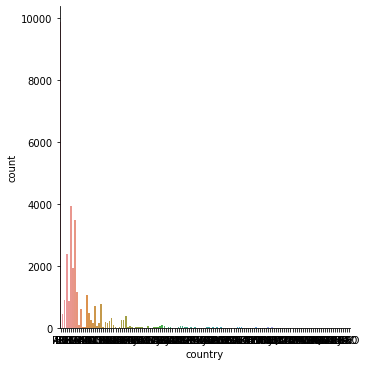

In [26]:
for column in categorical:
    
    sns.catplot(data=train, x=column, kind='count')
    print(f'Распределение {column} в обучающем',train[column].value_counts())
    sns.catplot(data=test, x=column, kind='count')
    print(f'Распределение {column} в тестовом',test[column].value_counts())


    

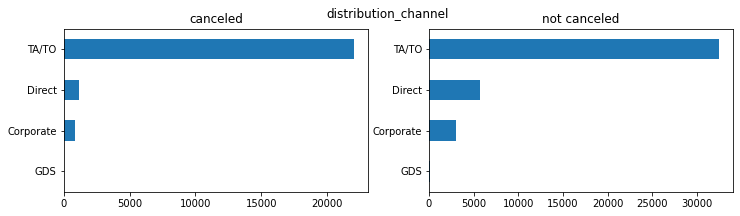

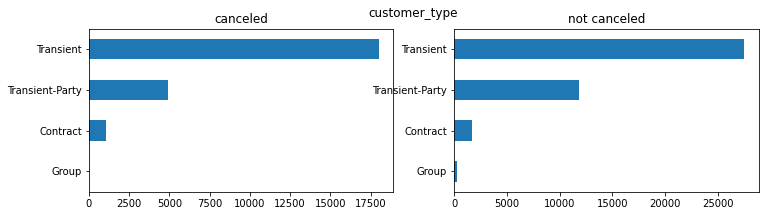

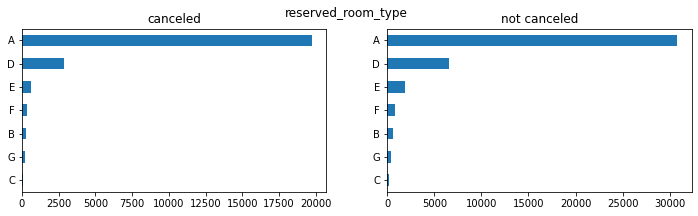

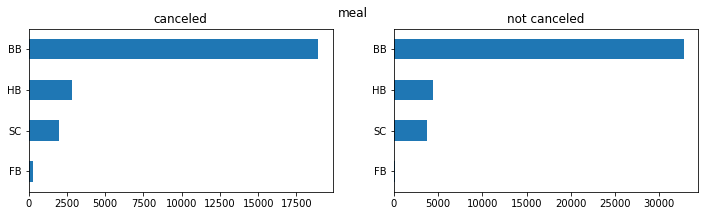

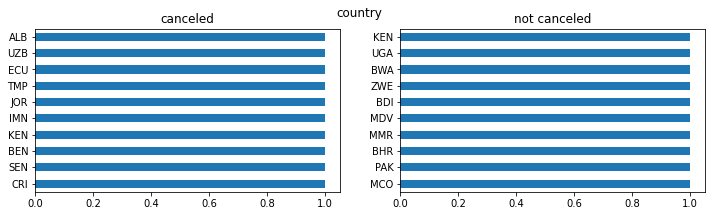

In [27]:
for col in train[categorical].columns:
    fig,ax = plt.subplots(1,2,figsize=(12,3))
    plt.suptitle(col)

    train[categorical][col][train['is_canceled']==1].value_counts(ascending=True)[:10].plot(kind='barh', ax=ax[0], title='canceled')
    train[categorical][col][train['is_canceled']==0].value_counts(ascending=True)[:10].plot(kind='barh', ax=ax[1], title='not canceled')


The ratio of categorical attributes is approximately the same in both datasets. No dependencies could be identified.



In [28]:
train[numeric].describe()

,lead_time,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list
count,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000
mean,96.340135,0.128919,0.107716,0.194245,3.334524
std,96.128157,0.965340,1.326658,0.593830,18.239876
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,0.000000,0.000000
50%,64.000000,0.000000,0.000000,0.000000,0.000000
75%,151.000000,0.000000,0.000000,0.000000,0.000000
max,374.000000,26.000000,58.000000,17.000000,259.000000


array([[<AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>],
       [<AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>],
       [<AxesSubplot:title={'center':'days_in_waiting_list'}>,
        <AxesSubplot:>]], dtype=object)

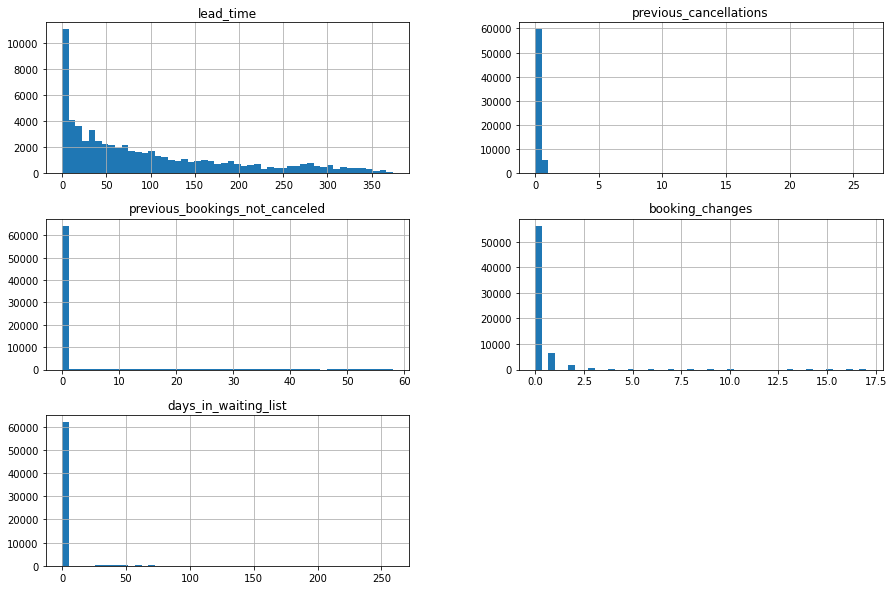

In [29]:
train[numeric].hist(bins=50, figsize=(15,10))

In [30]:
train[numeric].join(train['is_canceled']).groupby('is_canceled').mean().T

is_canceled,0,1
lead_time,72.238958,137.621070
previous_cancellations,0.016050,0.322243
previous_bookings_not_canceled,0.153898,0.028614
booking_changes,0.259087,0.083181
days_in_waiting_list,2.277493,5.145026


In [31]:
numerical = test.drop(columns=[*categorical, 'arrival_date_year','arrival_date_month'], axis=1)

<AxesSubplot:>

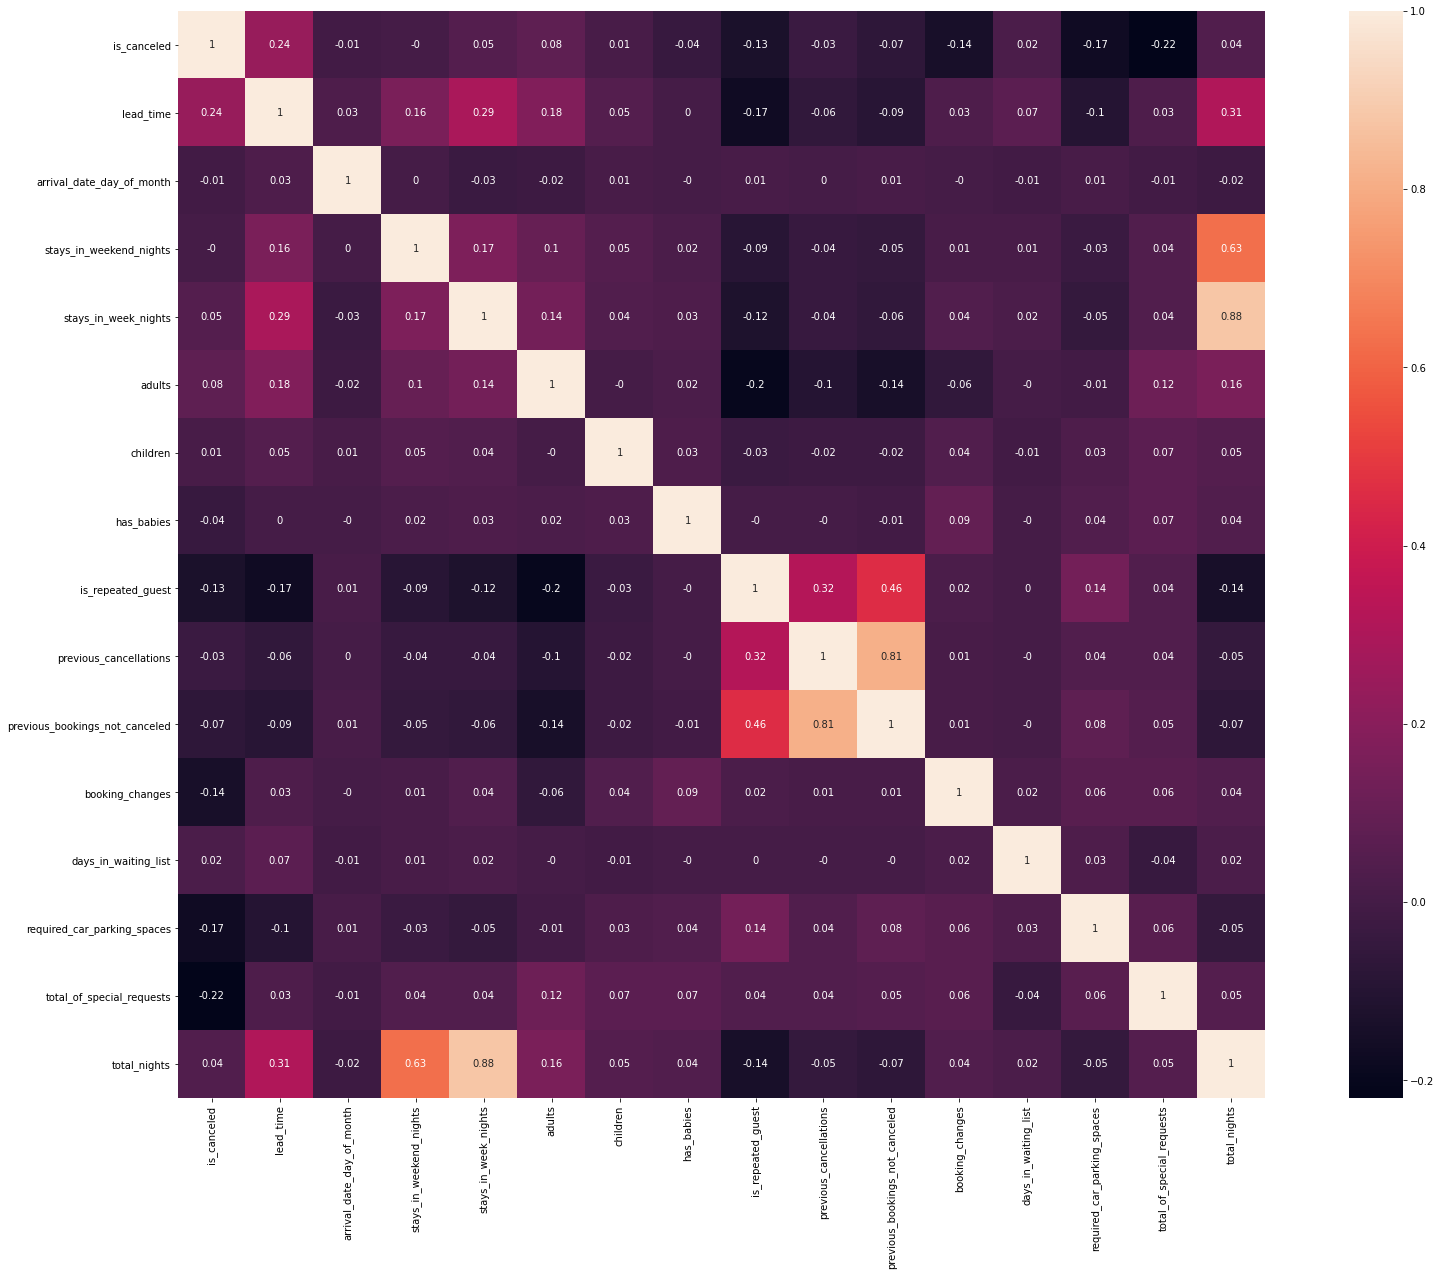

In [32]:
plt.figure(figsize=(30,20))
sns.heatmap(numerical.corr().round(2),annot=True,square=True)


We see a positive correlation between lead_time and is_cancelled. And a negative correlation between is_cancelled and total_of_special_requests

For guests who canceled their reservation:

* The average number of days between booking date and arrival date is almost twice as high (132.7 days)
* 20 times higher average number of previous cancellations
* 10 times lower average number of previous confirmed reservations
* 2.6 times lower average number of changes in booking parameters.
* 2 times longer on average their order was waiting for confirmation

array([[<AxesSubplot:title={'center':'stays_in_weekend_nights'}>,
        <AxesSubplot:title={'center':'stays_in_week_nights'}>,
        <AxesSubplot:title={'center':'adults'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'required_car_parking_spaces'}>,
        <AxesSubplot:title={'center':'total_of_special_requests'}>],
       [<AxesSubplot:title={'center':'total_nights'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

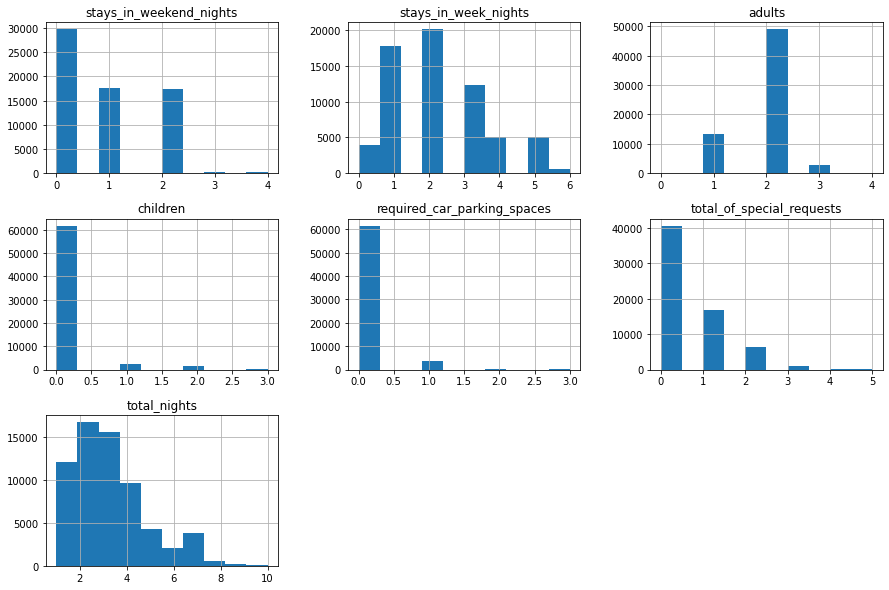

In [33]:
train[numeric_cat].hist(bins=10, figsize=(15,10))

In [34]:
train[numeric_cat].join(train['is_canceled']).groupby('is_canceled').mean().T

is_canceled,0,1
stays_in_weekend_nights,0.834155,0.809807
stays_in_week_nights,2.213802,2.243678
adults,1.820023,1.864956
children,0.079426,0.067127
required_car_parking_spaces,0.089721,0.000000
total_of_special_requests,0.660588,0.259566
total_nights,3.047957,3.053485


Customers who canceled their reservations have mostly

* No request for a parking space
* No children under 3 years old
* The average number of special marks is 2 times less.

array([[<AxesSubplot:title={'center':'arrival_date_year'}>,
        <AxesSubplot:title={'center':'arrival_date_day_of_month'}>]],
      dtype=object)

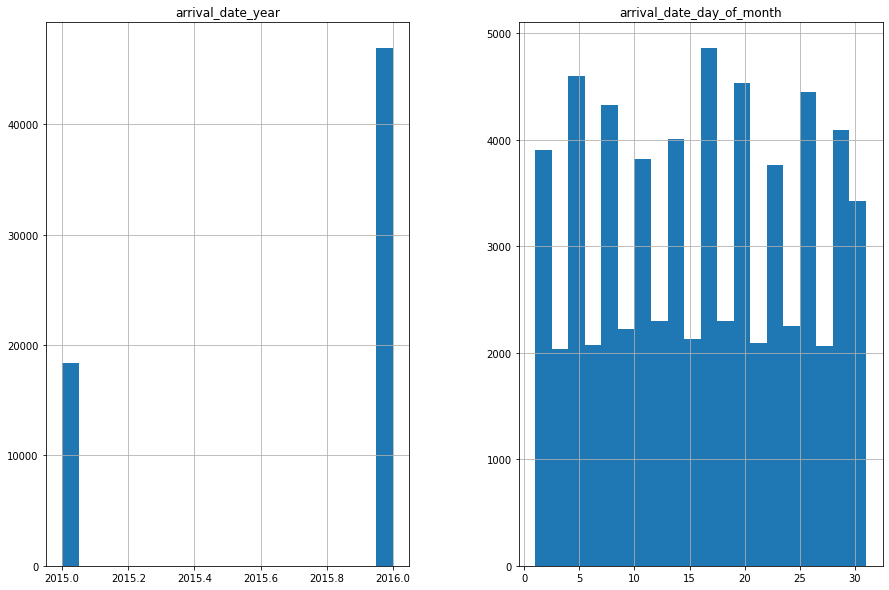

In [35]:
train[date_time].hist(bins=20, figsize=(15,10))

<AxesSubplot:>

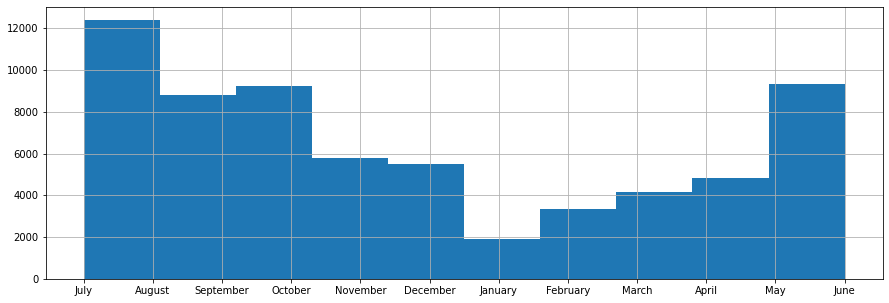

In [36]:
train['arrival_date_month'].hist(figsize=(15,5))


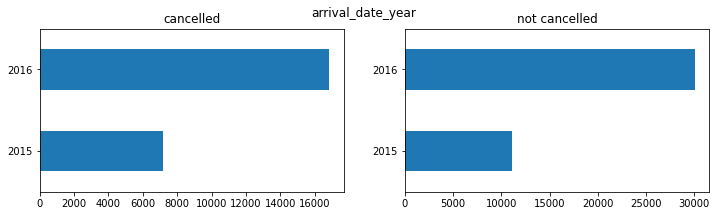

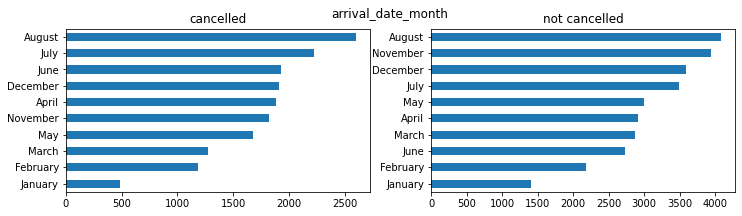

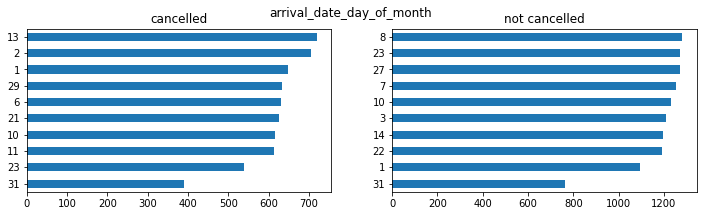

In [37]:
for col in train[date_time].columns:
    fig,ax = plt.subplots(1,2, figsize=(12,3))
    plt.suptitle(col)
  
    train[date_time][col][train['is_canceled']==1].value_counts(ascending=True)[:10].plot(kind='barh',ax=ax[0], title='cancelled')
    train[date_time][col][train['is_canceled']==0].value_counts(ascending=True)[:10].plot(kind='barh',ax=ax[1], title='not cancelled')


The dependence has not been revealed.

The arrival_date_year attribute cannot tell us anything about seasonal trends and is hardly useful for predicting the client's behavior in the future. Let's remove it

In [38]:
test = test.drop(columns='arrival_date_year', axis=1)
train = train.drop(columns='arrival_date_year', axis=1)

### Withdrawal

Guests who canceled their reservations have:

* The average number of days between booking date and arrival date is almost twice as long (132.7 days)
* 20 times higher average number of previous cancellations
* 10 times lower average number of previous confirmed reservations
* 2.5 times lower average number of changes in booking parameters
* Twice as long on average a reservation waited for confirmation
* No request for a parking space
* No children under 3 years old
* Average number of special marks is 2 times lower

In [39]:
print(train.loc[train['adults']==0, 'children'].value_counts())
print(test.loc[test['adults']==0, 'children'].value_counts())


2    141
0     15
3      8
1      2
Name: children, dtype: int64
2.0    58
0.0     7
3.0     2
1.0     2
Name: children, dtype: int64


 Indeed it appears that we have records where there are 0 adults and 0 children (who checked in then?) and 1 to 3 children. Let's take them out.


In [40]:
train = train.query('adults > 0')
test = test.query('adults > 0')


In [41]:
print(train.loc[train['adults']==0, 'children'].value_counts())
print(test.loc[test['adults']==0, 'children'].value_counts())

Series([], Name: children, dtype: int64)
Series([], Name: children, dtype: int64)


In [42]:
print(train[train['total_nights'] != (train['stays_in_week_nights']+train['stays_in_weekend_nights'])].count())

is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
has_babies                        0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


We found that total_nights contains the number of full nights, so the columns `stays_in_week_nights` and `stays_in_weekend_nights` are not needed. Let's remove them


In [43]:
test = test.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)
train = train.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)


## Step 3: Formulate an ML problem based on a business problem

Create dictionaries for revenues and costs and make them into dfs


In [44]:
room_profit = {'room_type'   : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
               'room_profit' : [1000, 800, 600, 550, 500, 450, 350, 300],
               'room_expense': [400,  350, 350, 150, 150, 150, 150, 100]}

season_ratio = {'season_month'  : ['June', 'July', 'August', 'September', 'October', 'November', 'December',
                                   'January', 'February', 'March', 'April', 'May' ],
                'season_ratio' :  [1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1, 1, 1, 1.2, 1.2, 1.2]}

In [45]:
rp_df = pd.DataFrame(room_profit)
sr_df = pd.DataFrame(season_ratio)

In [46]:
rp_df

,room_type,room_profit,room_expense
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150
7,H,300,100


In [47]:
rp_df

,room_type,room_profit,room_expense
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150
7,H,300,100


In [48]:
profit_df = train.join(rp_df.set_index('room_type'), on='reserved_room_type', how='left')\
                 .join(sr_df.set_index('season_month'), on='arrival_date_month', how='left')

profit_df.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,has_babies,meal,country,distribution_channel,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_profit,room_expense,season_ratio
0,0,7,July,1,1,0,0,BB,GBR,Direct,...,A,0,0,Transient,0,0,1,1000,400,1.4
1,0,14,July,1,2,0,0,BB,GBR,TA/TO,...,A,0,0,Transient,0,1,2,1000,400,1.4
2,0,0,July,1,2,0,0,BB,PRT,Direct,...,C,0,0,Transient,0,0,2,600,350,1.4
3,0,9,July,1,2,0,0,FB,PRT,Direct,...,C,0,0,Transient,0,1,2,600,350,1.4
4,1,85,July,1,2,0,0,BB,PRT,TA/TO,...,A,0,0,Transient,0,1,3,1000,400,1.4


Calculate the revenue from each order

In [49]:
profit_df['income'] = profit_df['total_nights'] * profit_df['room_profit'] * profit_df['season_ratio']

Let's calculate the total number of cleanings at the time of the order

In [50]:
profit_df['num_clean'] = 1 + profit_df['total_nights'].apply(lambda x: 1 if x==1 else np.ceil(x/2))

In [51]:
profit_df.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,adults,children,has_babies,meal,country,distribution_channel,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_profit,room_expense,season_ratio,income,num_clean
0,0,7,July,1,1,0,0,BB,GBR,Direct,...,0,Transient,0,0,1,1000,400,1.4,1400.0,2.0
1,0,14,July,1,2,0,0,BB,GBR,TA/TO,...,0,Transient,0,1,2,1000,400,1.4,2800.0,2.0
2,0,0,July,1,2,0,0,BB,PRT,Direct,...,0,Transient,0,0,2,600,350,1.4,1680.0,2.0
3,0,9,July,1,2,0,0,FB,PRT,Direct,...,0,Transient,0,1,2,600,350,1.4,1680.0,2.0
4,1,85,July,1,2,0,0,BB,PRT,TA/TO,...,0,Transient,0,1,3,1000,400,1.4,4200.0,3.0


Now let's calculate the cost per order, the total revenue from the business and the average profit of the order

In [52]:
# per-order charges
profit_df.loc[profit_df['is_canceled']==1, 'expense'] = profit_df['room_expense'] * profit_df['season_ratio'] + profit_df['room_profit']
profit_df.loc[profit_df['is_canceled']==0, 'expense'] = profit_df['room_expense'] * profit_df['num_clean']

In [53]:
 # total income
income = profit_df[profit_df['is_canceled']==0]['income'].sum()
expense = profit_df['expense'].sum()

profit = (income - expense)/1000000
profit

60.84585

In [54]:
# average revenue per order
profit_mean = profit/len(train)*1000000
profit_mean

935.212339189376

 #### Conclusion
 - total revenue of the current business plan is 61 mln rubles 
 - the current business model allows you to receive an average of 936 rubles per order

## Step 4: Develop an ML model

I will use scaling for quantitative features, and use one-hot encoding for categorical features. I will also check classes for imbalance.

To select the best hyperparameters I will use GridSearch

I will use DecisionTree,RandomForest for training.

In [55]:
features_train = train.drop(['is_canceled'], axis=1)
target_train = train['is_canceled']

features_test = test.drop(['is_canceled'], axis=1)
target_test = test['is_canceled']

In [56]:
features_train.columns

Index(['lead_time', 'arrival_date_month', 'arrival_date_day_of_month',
       'adults', 'children', 'has_babies', 'meal', 'country',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')

In [62]:
# list of quantitative columns
numeric = [
    'lead_time', 'arrival_date_day_of_month', 
     'adults', 'children', 'has_babies', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
    'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'
]

In [63]:
 # scaling attributes
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [64]:
# пChecking classes for imbalance 
print(train.query('is_canceled==1').shape)
print('----------------')
print(train.query('is_canceled == 0').shape)

(23996, 20)
----------------
(41065, 20)


There is an imbalance, so I will set the weight parameter class_weight=balanced

In [65]:
# convert categorical attributes into quantitative attributes
catcols = [*categorical, 'arrival_date_month']

ftrain_encoder = features_train.loc[:]

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(ftrain_encoder[catcols])
ftrain_encoded = encoder.transform(ftrain_encoder[catcols]).toarray()

ftrain_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
features_train_df = pd.DataFrame(
    ftrain_encoded,
    columns=encoder.get_feature_names(catcols),
    index=features_train.index
)
features_train_df.head()

,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_A,reserved_room_type_B,...,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
features_train_drop_cat = features_train.drop(catcols, axis=1)
features_train_drop_cat.head()

,lead_time,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,-0.928977,-1.696877,-1.783139,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,-0.680536,-1.178757
1,-0.856193,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,0.649323,-0.603486
2,-1.001761,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,-0.680536,-0.603486
3,-0.908181,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,0.649323,-0.603486
4,-0.117955,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,0.649323,-0.028215


In [68]:
features_train_ohe = pd.concat((features_train_drop_cat,features_train_df), axis=1)
features_train_ohe.head()

,lead_time,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,-0.928977,-1.696877,-1.783139,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.856193,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.001761,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.908181,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.117955,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# do the same for the test sample
ftest_encoder = features_test.loc[:]

features_test_enc = encoder.transform(ftest_encoder[catcols]).toarray()
features_test_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
features_test_df = pd.DataFrame(
    features_test_enc,
    columns=encoder.get_feature_names(catcols),
    index=features_test.index
)

features_test_df.head()

,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_A,reserved_room_type_B,...,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
features_test_drop_cat = features_test.drop(catcols, axis=1)
features_test_drop_cat.head()

,lead_time,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,-0.232330,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,-0.680536,-1.178757
1,-0.357102,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,0.649323,0.547056
2,-0.357102,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,0.649323,0.547056
3,-0.263523,-1.696877,-1.783139,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,0.649323,0.547056
4,0.786647,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,-0.244332,-0.680536,2.272869


In [72]:
features_test_ohe = pd.concat((features_test_drop_cat, features_test_df), axis=1)
features_test_ohe.head()

,lead_time,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,...,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,-0.232330,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.357102,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.357102,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.263523,-1.696877,-1.783139,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.786647,-1.696877,0.336436,-0.219336,-0.083175,0,-0.133707,-0.081287,-0.326674,-0.183057,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обучим RandomForest и DecisionTree

 Let's choose the metric for the task: f1_score. In this task we care about both the completeness of the model's predictions (it is important that the model can recognize as many customers who canceled the reservation as possible) and its accuracy (it is important that among those customers that the model marked as unreliable, as many as possible would actually be unreliable).


In [73]:
random_forest = RandomForestClassifier(random_state=123, class_weight='balanced')

In [74]:
params = {
    'n_estimators': [75,100,125],
    'max_depth': [10,16,20],
    'max_features': [3,5,7]
}

In [75]:
%%time
grid = GridSearchCV(random_forest, params,n_jobs=-1, verbose=1,cv=8, scoring='f1')
grid.fit(features_train_ohe, target_train)

Fitting 8 folds for each of 27 candidates, totalling 216 fits
CPU times: user 10min 9s, sys: 16.4 s, total: 10min 25s
Wall time: 10min 26s


GridSearchCV(cv=8,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [10, 16, 20], 'max_features': [3, 5, 7],
                         'n_estimators': [75, 100, 125]},
             scoring='f1', verbose=1)

In [76]:
grid.best_params_

{'max_depth': 10, 'max_features': 5, 'n_estimators': 125}

In [77]:
grid.best_score_

0.6166609061804125

In [78]:
# DecisionTree

decision_tree = DecisionTreeClassifier(random_state=123, class_weight='balanced')

In [79]:
parames = {
    'max_depth':[10,16,19],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4]
}

In [80]:
%%time
grid = GridSearchCV(decision_tree, parames, n_jobs=-1, cv=8, scoring='f1')
grid.fit(features_train_ohe, target_train)

CPU times: user 1min 57s, sys: 13 s, total: 2min 10s
Wall time: 2min 10s


GridSearchCV(cv=8,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [10, 16, 19],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1')

In [81]:
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [82]:
grid.best_score_

0.573836926279961

**Conclusion:** the best quality score for random forest is 0.61

In [83]:
# тестовая выборка
rf_model = RandomForestClassifier(
    max_depth=10,
    n_estimators=125,
    max_features=5,
    class_weight='balanced',
    random_state=123,
    n_jobs=-1)

rf_model.fit(features_train_ohe, target_train)

predictions_rf = rf_model.predict(features_test_ohe)
f1_score_rf = f1_score(target_test, predictions_rf)

print("F1-мера для модели случайного леса на тестовой выборке:", f1_score_rf)


F1-мера для модели случайного леса на тестовой выборке: 0.6312090874085483


Conclusion: thus, the random forest model is selected to predict customer churn. It shows a key metric F1-measure equal to 0.639 with an average model quality score of ~0.63.

Just in case, let's look at the AUC-ROc to see how different the model is from the random model

In [84]:
auc_roc_decision_tree = roc_auc_score(target_test, rf_model.predict_proba(features_test_ohe)[:,1])
auc_roc_decision_tree

0.8330313479275617

**Conclusion:** Quality metric above 0.5 means trained model predicts better than random model

In [85]:
test['predicted'] = predictions_rf

In [86]:
test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

In [87]:
profit = test.join(rp_df.set_index('room_type'), on='reserved_room_type', how='left')\
             .join(sr_df.set_index('season_month'), on='arrival_date_month', how='left')

profit['total_expense'] = profit['total_nights'].apply(lambda x: 1 if x==1 else np.ceil(x/2))*profit['room_expense']


In [88]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32343 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32343 non-null  int64  
 1   lead_time                       32343 non-null  float64
 2   arrival_date_month              32343 non-null  object 
 3   arrival_date_day_of_month       32343 non-null  int64  
 4   adults                          32343 non-null  float64
 5   children                        32343 non-null  float64
 6   has_babies                      32343 non-null  float64
 7   meal                            32343 non-null  object 
 8   country                         32343 non-null  object 
 9   distribution_channel            32343 non-null  object 
 10  is_repeated_guest               32343 non-null  int64  
 11  previous_cancellations          32343 non-null  int64  
 12  previous_bookings_not_canceled  

In [89]:
def calc_profit(row):
    room_price = row['room_profit']
    seasonal = row['season_ratio']
    total_nights =  row['total_nights']
    
    if row['predicted'] == 1 and row['is_canceled'] ==1:
        return (room_price*seasonal)*0.8 - row['room_expense']
    elif row['predicted'] == 0 and row['is_canceled'] == 1:
        return row['room_expense']+ seasonal*room_price
    else:
        revenue = total_nights * room_price * seasonal
        return revenue - row['total_expense']
    
profit['profit_predicted'] = profit.apply(calc_profit, axis=1)

In [90]:


print('Прибыль с внедрением модели:', profit['profit_predicted'].sum()/1000000 )



Прибыль с внедрением модели: 64.937392


In [92]:
profit.loc[profit['is_canceled']==0,'income_no_ml'] = (profit['total_nights'] * profit['room_profit'] * profit['season_ratio'])-profit['total_expense']
profit.loc[profit['is_canceled']==1,'income_no_ml'] = -profit['room_expense'] - profit['room_profit']

print('Прибыль без внедрения модели:', profit['income_no_ml'].sum()/1000000)


Прибыль без внедрения модели: 37.83331


**Conclusion:** implementation of the model will help generate ~30 million in additional revenue

## Step 5: Describe the profile of an "unreliable" client

Based on the obtained model, let's make a portrait of an unreliable client. First, let's consider the significance of the attributes

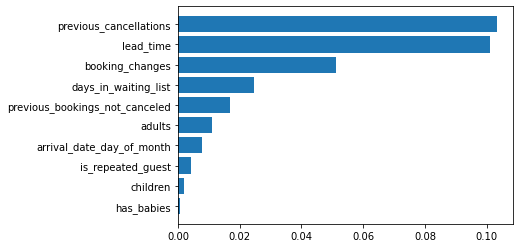

In [93]:
test_ohe_cols = features_test_ohe.columns
f_i = list(zip(test_ohe_cols,rf_model.feature_importances_))[:10]
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

The most significant attributes were
- number of canceled orders from the customer
- number of days between booking date and arrival date
- number of nights on weekdays
- number of confirmed bookings with the customer
- number of adult guests

Let's see exactly how these values affect the cancellation of bookings.

<AxesSubplot:>

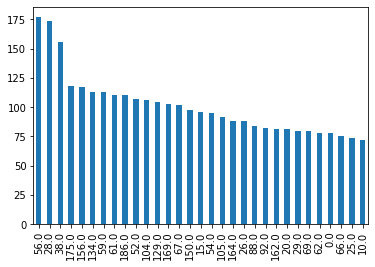

In [94]:
test.loc[test['is_canceled']==1,'lead_time'].value_counts()[:10].plot(kind='bar')

Most cancellations are observed for the 56 day mark between the booking date and arrival date

<AxesSubplot:>

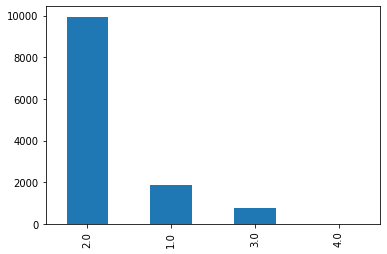

In [95]:
test.loc[test['is_canceled']==1,'adults'].value_counts().plot(kind='bar')

<AxesSubplot:>

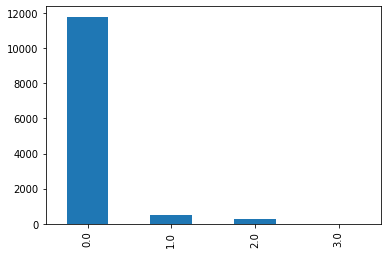

In [96]:
test.loc[test['is_canceled']==1,'children'].value_counts().plot(kind='bar')

<AxesSubplot:>

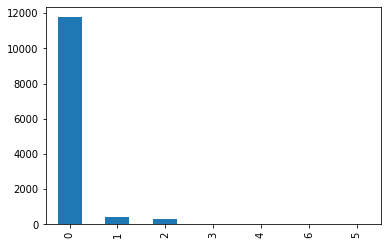

In [98]:
test.loc[test['is_canceled']==1,'booking_changes'].value_counts().plot(kind='bar')

<AxesSubplot:>

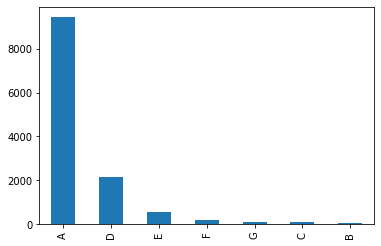

In [99]:
test.loc[test['is_canceled']==1,'reserved_room_type'].value_counts().plot(kind='bar')


<AxesSubplot:>

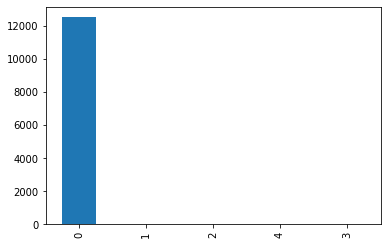

In [103]:
test.loc[test['is_canceled']==1,'previous_cancellations'].value_counts().plot(kind='bar')


<AxesSubplot:>

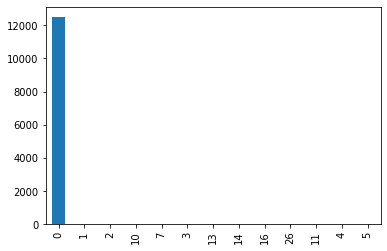

In [107]:
test.loc[test['is_canceled']==1,'previous_bookings_not_canceled'].value_counts().plot(kind='bar')


<AxesSubplot:>

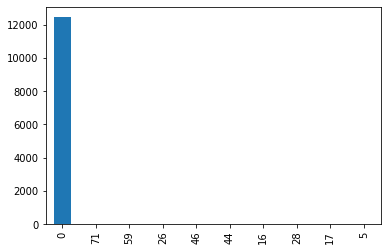

In [109]:
test.loc[test['is_canceled']==1,'days_in_waiting_list'].value_counts()[:10].plot(kind='bar')


More cancellations for 2 and 3 night stays

The portrait of a client who is considered 'unreliable' is as follows: the client plans to stay from 1 to 3 days inclusive and books the most expensive class 'A' room for two people and no children.

## Step 6. Write a general conclusion

Two ML models were trained to solve the problem and the best one, a random forest model with hyperparameters, was selected based on the results of cross-validation:

On the test data, the model showed a value of F1-measure metric equal to 0.6199. 

Calculated business metric: Profit after implementing the model is 18 million more than profit without implementing churn prediction system.

Portrait of an "unreliable" customer for the customer: the customer books the most expensive room category ("A") for two people, without children, planning to stay from 1 to 3 days inclusive.